In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import pandas as pd
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

# Load the CSV files
alpha1 = pd.read_csv("alpha1_pos.csv", parse_dates=['Date'])
alpha2 = pd.read_csv("alpha3_pos.csv", parse_dates=['Date'])
alpha3 = pd.read_csv("alpha2_pos.csv", parse_dates=['Date'])
# alpha4 = pd.read_csv("alpha4_pos.csv", parse_dates=['Date'])

# Merge the DataFrames sequentially
merged = pd.merge(alpha1, alpha2, on=["Date", "Close"], how="inner")
merged = pd.merge(merged, alpha3, on=["Date", "Close"], how="inner")
# merged = pd.merge(merged, alpha4, on=["Date", "Close"], how="inner")

# Display the first 10 rows
merged.head(10)

Loading ITables v2.5.2 from the internet... (need help?)


In [21]:
import matplotlib.pyplot as plt

In [22]:
# Pearson correlation
corr_pearson = merged['pos_x'].corr(merged['pos_y'], method='pearson')
print("Pearson:", corr_pearson)
corr_pearson = merged['pos'].corr(merged['pos_y'], method='pearson')
print("Pearson:", corr_pearson)
corr_pearson = merged['pos'].corr(merged['pos_x'], method='pearson')
print("Pearson:", corr_pearson)

# Spearman correlation
corr_spearman = merged['pos_x'].corr(merged['pos_y'], method='spearman')

print("Spearman:", corr_spearman)
corr_spearman = merged['pos_y'].corr(merged['pos'], method='spearman')

print("Spearman:", corr_spearman)
corr_spearman = merged['pos_x'].corr(merged['pos'], method='spearman')


print("Spearman:", corr_spearman)


Pearson: 0.5124601981306695
Pearson: 0.5896458418821554
Pearson: 0.4626425608650835
Spearman: 0.5198542676244493
Spearman: 0.587895912611108
Spearman: 0.46466850748206073


In [23]:
merged

Loading ITables v2.5.2 from the internet... (need help?)


In [24]:
merged['Vector_final_1'] = list(zip(merged['pos_x'], merged['pos_y'], merged['pos']))
unique_vectors = merged['Vector_final_1'].unique()
unique_vectors

array([(0, 0, 0), (0, 0, -1), (0, 0, 1), (0, 1, 0), (0, 1, 1), (0, -1, 0),
       (0, -1, -1), (1, 1, 1), (1, 0, 1), (1, 0, 0), (1, 1, 0),
       (1, 0, -1), (-1, -1, -1), (-1, 0, 0), (-1, 0, -1), (-1, -1, 0)],
      dtype=object)

In [25]:
from F4 import BacktestInformation

In [27]:
import optuna
def objective(trial):
    mapping = {}
    vec_zero = (0,0)  # hoặc tuple đại diện cho không tín hiệu

    for vec in unique_vectors:
        if vec == vec_zero:
           mapping[vec] = 0  # luôn gán 0 cho (0, 0, 0)
        else:
            mapping[vec] = trial.suggest_categorical(str(vec), [-1, 0, 1])

    # Tạo cột Final_Pos dựa trên ánh xạ
    merged['Vector_pos_combo'] = merged['Vector_final_1'].map(mapping)

    # Tính hiệu suất của chiến lược dựa trên Final_Pos
    try:
        backtest_info = BacktestInformation(
            merged['Date'],
            merged['Vector_pos_combo'],
            merged['Close'],
            fee=0.3
        )
        sharpe = backtest_info.Sharp_after_fee()
        profit = backtest_info.Profit_per_year()
        if profit is None or isinstance(profit, str):
            return -999
        return sharpe

    except Exception as e:
        return -999
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4000)

print("Best Sharpe:", study.best_value)
print("Best Mapping:", study.best_params)

[I 2025-09-18 16:56:35,228] A new study created in memory with name: no-name-2c060fed-9bb6-443e-8a85-d42613b05816
[I 2025-09-18 16:56:35,593] Trial 0 finished with value: -2.4 and parameters: {'(0, 0, 0)': 1, '(0, 0, -1)': 1, '(0, 0, 1)': 0, '(0, 1, 0)': -1, '(0, 1, 1)': 1, '(0, -1, 0)': 1, '(0, -1, -1)': -1, '(1, 1, 1)': -1, '(1, 0, 1)': -1, '(1, 0, 0)': 0, '(1, 1, 0)': -1, '(1, 0, -1)': 0, '(-1, -1, -1)': -1, '(-1, 0, 0)': 1, '(-1, 0, -1)': -1, '(-1, -1, 0)': 1}. Best is trial 0 with value: -2.4.
[I 2025-09-18 16:56:35,727] Trial 1 finished with value: 0.46 and parameters: {'(0, 0, 0)': 0, '(0, 0, -1)': 1, '(0, 0, 1)': 1, '(0, 1, 0)': -1, '(0, 1, 1)': 0, '(0, -1, 0)': 0, '(0, -1, -1)': -1, '(1, 1, 1)': 1, '(1, 0, 1)': 1, '(1, 0, 0)': 0, '(1, 1, 0)': 1, '(1, 0, -1)': 0, '(-1, -1, -1)': -1, '(-1, 0, 0)': 1, '(-1, 0, -1)': -1, '(-1, -1, 0)': 0}. Best is trial 1 with value: 0.46.
[I 2025-09-18 16:56:35,849] Trial 2 finished with value: -1.41 and parameters: {'(0, 0, 0)': 0, '(0, 0, -1)':

Best Sharpe: 2.6
Best Mapping: {'(0, 0, 0)': 0, '(0, 0, -1)': 0, '(0, 0, 1)': 0, '(0, 1, 0)': 0, '(0, 1, 1)': 0, '(0, -1, 0)': -1, '(0, -1, -1)': -1, '(1, 1, 1)': 1, '(1, 0, 1)': 1, '(1, 0, 0)': 1, '(1, 1, 0)': 1, '(1, 0, -1)': 1, '(-1, -1, -1)': 0, '(-1, 0, 0)': 0, '(-1, 0, -1)': -1, '(-1, -1, 0)': -1}


Margin: 11.44
MDD: 54.8 (3.51%)

   Total trading quantity: 1080
         Profit per trade: 2.04
             Total Profit: 2708.4
         Profit after fee: 2199.9
 Trading quantity per day: 0.57
 Profit per day after fee: 1.16
                   Return: 0.18
          Profit per year: 288.73
                  HitRate: 0.5
          HitRate per day: 0.33


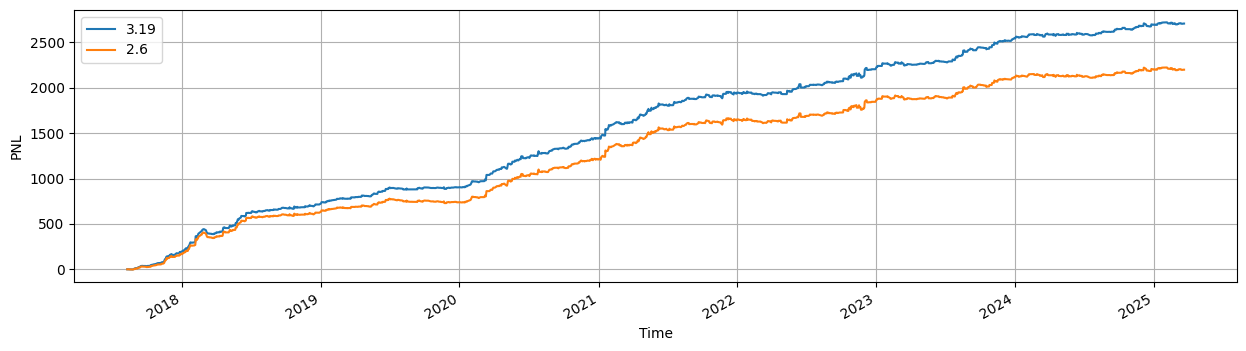

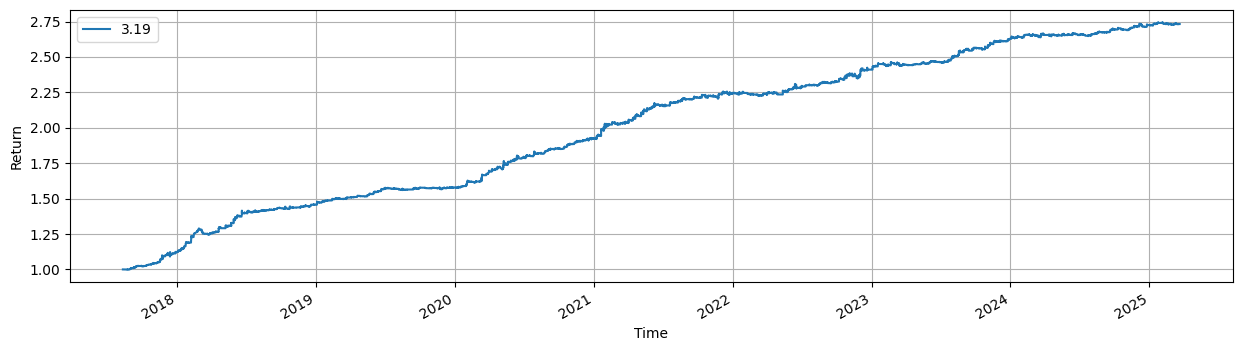

Loading ITables v2.5.2 from the internet... (need help?)


In [28]:
import ast
import numpy as np
import pandas as pd

# 1) Define raw_map (mapping from tuple strings to positions)
raw_map = study.best_params
# 2) Convert raw_map to tuple_map with tuple keys
tuple_map = {ast.literal_eval(k): v for k, v in raw_map.items()}
tuple_map[(0, 0, 0, 0)] = 0  # Add 4-element tuple case

# 3) Function to convert Vector_final_1 to tuple
def to_tuple(x):
    try:
        if isinstance(x, str):
            return tuple(ast.literal_eval(x))  # Parse string to tuple
        elif isinstance(x, (list, tuple, np.ndarray)):
            return tuple(x)  # Convert list/array to tuple
        else:
            return np.nan  # Return NaN for invalid types
    except (ValueError, SyntaxError):
        return np.nan  # Return NaN if parsing fails

# Apply to_tuple to create Vector_final_1_tuple
merged['Vector_final_1_tuple'] = merged['Vector_final_1'].apply(to_tuple)

# 4) Map tuples to positions, handle NaN and non-matching keys
def map_position(t):
    return tuple_map.get(t, 0)  # Default to 0 if tuple not in tuple_map

merged['Pos_final'] = merged['Vector_final_1_tuple'].apply(map_position).astype(int)

# 5) Backtest
backtest_info = BacktestInformation(
    merged['Date'],
    merged['Pos_final'],
    merged['Close'],
    fee=0.3
)
backtest_info.Plot_PNL()